<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#1.1.-Вывод" data-toc-modified-id="1.1.-Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1.1. Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-стохастического-градиентного-бустинга" data-toc-modified-id="Модель-стохастического-градиентного-бустинга-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Модель стохастического градиентного бустинга</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Разметка комментариев для интернет-магазина

**Цель проекта**: построить модель для классификации комментариев на позитивные и негативные для интернет-магазина. 

**Исходные данные**: в нашем распоряжении набор данных с разметкой о токсичности правок. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

**Критерий оценки**: метрика качества *F1* модели должна быть не меньше 0.75 

**Этапы проекта:**
1. Подготовка данных
    - изучение данных
    - изучение баланса классов
    - очистка и лемматизация
2. Построение моделей:
    - подготовка тренировочной и тестовой выборок
    - логистическая регрессия
    - случайный лес
    - стохастический градиентный бустинг
3. Тестирование моделей
4. Выводы

## Подготовка данных

In [36]:
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgbm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay

In [2]:
comments = pd.read_csv('toxic_comments.csv')
display(comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

В датасете 159 571 комментарий, пропусков нет, мы имеем дело с англоязычными пользователями.

Проанализируем баланс классов в данных: 

0    0.898
1    0.102
Name: toxic, dtype: float64

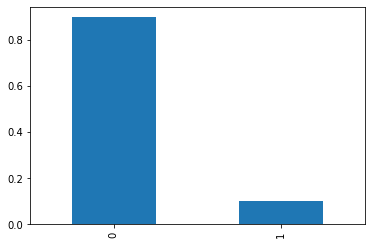

In [3]:
display(round(comments['toxic'].value_counts(normalize = True), 3))
comments['toxic'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

Налицо дисбаланс классов: токсичных комментариев выявлено горадо меньше, чем нетоксичных - 10% против 90%. 

Следующим шагом оставим для анализа только буквы латинского алфавита: 

In [4]:
# функция для очистки текста от лишних символов
def clear_text(text):
    clean_t = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(clean_t.split())

comments['clear_t'] = comments['text'].apply(lambda x: clear_text(x))

texts = comments['clear_t']
texts

0         Explanation Why the edits made under my userna...
1         D aww He matches this background colour I m se...
2         Hey man I m really not trying to edit war It s...
3         More I can t make any real suggestions on impr...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159566    And for the second time of asking when your vi...
159567    You should be ashamed of yourself That is a ho...
159568    Spitzer Umm theres no actual article for prost...
159569    And it looks like it was actually you who put ...
159570    And I really don t think you understand I came...
Name: clear_t, Length: 159571, dtype: object

Лемматизируем очищенные комментарии с помощью библиотеки NLTK:

In [5]:
# функция для определения части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
lemmatizer = WordNetLemmatizer()

# функция для лемматизации
def lemmatize(text):
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    lemm_text = " ".join(lemm_list)      
    return lemm_text

In [7]:
%%time
comments['lemmas'] = texts.apply(lambda x: lemmatize(x))
comments

Wall time: 1h 24min 31s


,text,toxic,clear_t,lemmas
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir be my hero Any chance you remember wha...
...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...,And for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...,You should be ashamed of yourself That be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...,Spitzer Umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...,And it look like it be actually you who put on...


Проверим, всё ли успешно лемматизировалось:

In [8]:
comments.loc[comments['lemmas'].isna()]

,text,toxic,clear_t,lemmas


Как видим, 7 строк содержали только символы и были почищены полностью. Удалим их:

In [9]:
comments.dropna(subset = ['lemmas'],inplace=True)
comments.loc[comments['lemmas'].isna()]

,text,toxic,clear_t,lemmas


In [10]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     159571 non-null  object
 1   toxic    159571 non-null  int64 
 2   clear_t  159571 non-null  object
 3   lemmas   159571 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


### 1.1. Вывод
В рамках предобработки комментарии были очищены от символов и лемматизированы. Обработанный датасет содержит 159 564 строки. Классы в датасете разбалансированы: только каждый 10й комментарий размечен как токсичный.

## Обучение

Поскольку целевой признак в нашем случае - бинарная переменная, перед нами стоит задача
классификации. Для этого будем использовать следующие модели:
- логистическую регрессию
- случайный лес
- модель градиентного бустинга на основе библиотеки LightGBM

Разделим датасет на тренировочную и тестовую выборку в соотношении 70/30:

In [11]:
train, test = train_test_split(comments, test_size = 0.3, random_state = 16, stratify = comments['toxic'])
print(train.shape, test.shape)

(111699, 4) (47872, 4)


Убедимся, что соотношение классов в полученных наборах примерно одинаково:

In [12]:
train['toxic'].value_counts(normalize = True)

0    0.898325
1    0.101675
Name: toxic, dtype: float64

In [13]:
test['toxic'].value_counts(normalize = True)

0    0.898312
1    0.101688
Name: toxic, dtype: float64

Загрузим словарь английских стоп-слов и обучим счётчик TF-IDF:

In [14]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_tf_idf = count_tf_idf.fit_transform(train['lemmas'])

Выделим целевой и обучающий признаки, в качестве обучающего примем результат работы счётчика TF-IDF:

In [15]:
train_features = train_tf_idf
train_target = train['toxic']

Поскольку классы в нашей выборке не сбалансированы, выполним апсемплинг с помощью библиотеки imblearn:

In [16]:
ros = RandomOverSampler(random_state = 16)
train_features_ros, train_target_ros = ros.fit_resample(train_features, train_target)
print(train_features_ros.shape, train_target_ros.shape)

(200684, 129233) (200684,)


Баланс классов после апсемплинга:

In [17]:
train_target_ros.value_counts(normalize = True)

0    0.5
1    0.5
Name: toxic, dtype: float64

Данные подготовлены и готовы к отправке в модель.

___
#### Модель логистической регрессии

In [18]:
log_model = LogisticRegression(random_state = 1, solver = 'liblinear', class_weight = 'balanced')
log_model.fit(train_features, train_target)
log_scores = cross_val_score(log_model, train_features, train_target, scoring = 'f1', cv = 3, n_jobs = -1)
print('Средняя оценка F1 модели логистической регрессии (с использованием внутреннего взвешивания):', 
      round(log_scores.mean(), 2))

Средняя оценка F1 модели логистической регрессии (с использованием внутреннего взвешивания): 0.74


In [19]:
log_balanced_model = LogisticRegression(random_state = 1, solver = 'liblinear')
log_balanced_model.fit(train_features_ros, train_target_ros)
log_balanced_scores = cross_val_score(log_balanced_model, train_features_ros, train_target_ros, scoring = 'f1', 
                                      cv = 3, n_jobs = -1)
print('Средняя оценка F1 модели логистической регрессии (на upsamle-выборке):', 
      round(log_balanced_scores.mean(), 2))

Средняя оценка F1 модели логистической регрессии (на upsamle-выборке): 0.96


Как видим, лучший результат модель показывает на upsamle-выборке.

___
#### Модель случайного леса

In [20]:
forest = RandomForestClassifier(random_state = 16, class_weight = 'balanced')
params = {'max_depth':range(1,10,2),
          'n_estimators': range(50,150,50)}
random_forest = RandomizedSearchCV(forest, params, random_state=16, cv = 3, scoring = 'f1', n_jobs = -1)
random_forest.fit(train_features_ros, train_target_ros)
print('Параметры лучшего случайного леса', random_forest.best_params_)
print('Лучшая модель случайного леса показала F1', round(random_forest.best_score_, 2))

Параметры лучшего случайного леса {'n_estimators': 100, 'max_depth': 9}
Лучшая модель случайного леса показала F1 0.79


___
#### Модель стохастического градиентного бустинга

In [21]:
lgbm_model = lgbm.LGBMClassifier(random_state = 16)
lgbm_model.fit(train_features_ros, train_target_ros)

lgbm_scores = cross_val_score(lgbm_model, train_features_ros, train_target_ros, scoring = 'f1', cv = 3, 
                              n_jobs = -1)
print('Средняя оценка F1 модели градиентного бустинга LGBM:', round(lgbm_scores.mean(), 2))

Средняя оценка F1 модели градиентного бустинга LGBM: 0.9


In [22]:
cat_model = CatBoostClassifier(iterations = 200,
                               depth = 5,
                               learning_rate = 1,
                               loss_function = 'Logloss',
                               eval_metric = 'F1',
                               verbose = False)

cat_model.fit(train_features_ros, train_target_ros)
print('Лучшая оценка F1 модели градиентного бустинга Catboost:', round(cat_model.best_score_['learn']['F1'], 2))

Лучшая оценка F1 модели градиентного бустинга Catboost: 0.95


Агрегируем результаты:

Cлучайный лес              0.79
Бустинг с LightGBM         0.90
Бустинг с Catboost         0.95
Логистическая регрессия    0.96
dtype: float64


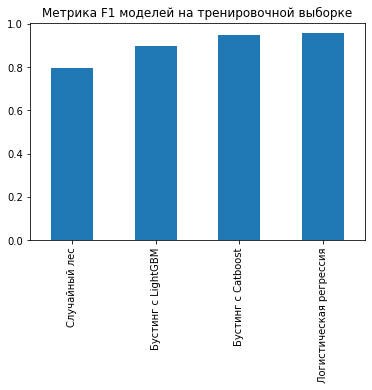

In [23]:
train_result_table = pd.Series([log_balanced_scores.mean(), random_forest.best_score_, 
                                lgbm_scores.mean(), cat_model.best_score_['learn']['F1']],
                               index = ['Логистическая регрессия', 'Cлучайный лес', 
                                        'Бустинг с LightGBM', 'Бустинг с Catboost'])
print(round(train_result_table, 2).sort_values()) 

train_result_table.sort_values().plot(kind = 'bar', title = 'Метрика F1 моделей на тренировочной выборке')
plt.show()

#### Вывод
Все четыре модели на тренировочной выборке показывают хороший результат: метрика F1 больше 0,75. Лучший результат показала модель логистической регрессии с F1, равным 0,96.

## Тестирование

In [24]:
test_tf_idf = count_tf_idf.transform(test['lemmas'])
test_features = test_tf_idf
test_target = test['toxic']

In [25]:
def test_model(model, name):
    predictions = model.predict(test_features)
    f1 = f1_score(test_target, predictions)
    cnf_matrix = metrics.confusion_matrix(test_target, predictions)
    ax = plt.axes()
    sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, fmt='.1%', ax = ax)
    ax.set_title('Матрица ошибок {}'.format(name))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print('F1 модели {}:'.format(name), round(f1, 2))

F1 модели логистическая регрессия: 0.75


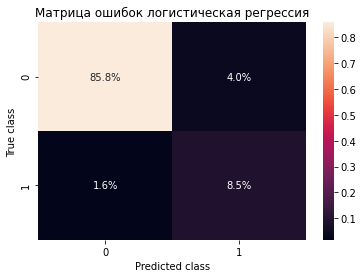

In [26]:
test_model(log_balanced_model, 'логистическая регрессия')
log_probabilities_one = log_balanced_model.predict_proba(test_features)[:,1]
fpr_log, tpr_log, thr_log = roc_curve(test_target, log_probabilities_one)

F1 модели градиентного бустинга LGBM: 0.73


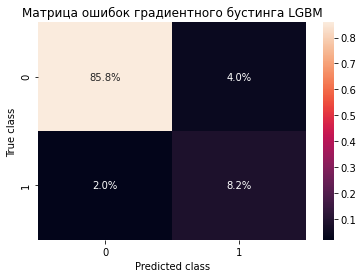

In [27]:
test_model(lgbm_model, 'градиентного бустинга LGBM')
lgbm_probabilities_one = lgbm_model.predict_proba(test_features)[:,1]
fpr_lgbm, tpr_lgbm, thr_lgbm = roc_curve(test_target, lgbm_probabilities_one)

F1 модели случайный лес: 0.34


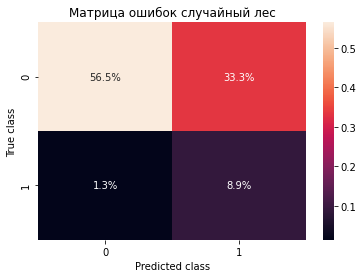

In [28]:
test_model(random_forest, 'случайный лес')
forest_probabilities_one = random_forest.predict_proba(test_features)[:,1]
fpr_forest, tpr_forest, thr_forest = roc_curve(test_target, forest_probabilities_one)

F1 модели градиентного бустинга Catboost: 0.71


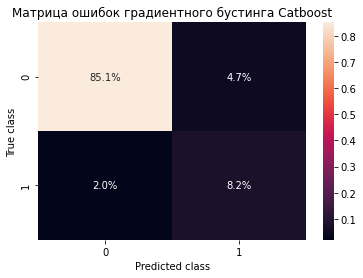

In [29]:
test_model(cat_model, 'градиентного бустинга Catboost')
cat_probabilities_one = cat_model.predict_proba(test_features)[:,1]
fpr_cat, tpr_cat, thr_cat = roc_curve(test_target, cat_probabilities_one)

Cлучайный лес              0.34
Бустинг с Catboost         0.71
Бустинг LightGBM           0.73
Логистическая регрессия    0.75
dtype: float64


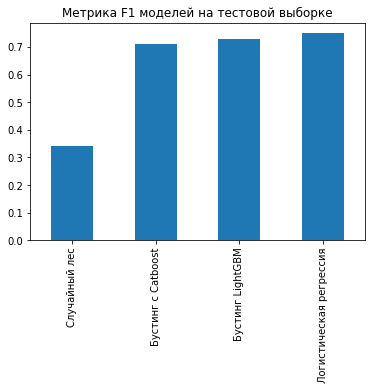

In [30]:
test_result_table = pd.Series([0.75, 0.34, 0.73, 0.71],
                               index = ['Логистическая регрессия', 'Cлучайный лес', 
                                        'Бустинг LightGBM', 'Бустинг с Catboost'])
print(round(test_result_table, 2).sort_values()) 

test_result_table.sort_values().plot(kind = 'bar', title = 'Метрика F1 моделей на тестовой выборке')
plt.show()

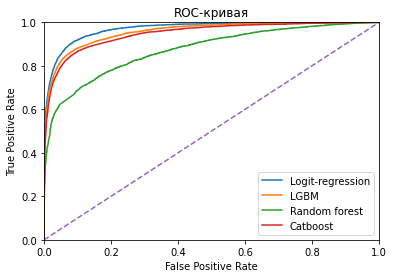

In [31]:
plt.figure()
plt.plot(fpr_log, tpr_log, label = 'Logit-regression')
plt.plot(fpr_lgbm, tpr_lgbm, label = 'LGBM')
plt.plot(fpr_forest, tpr_forest, label = 'Random forest')
plt.plot(fpr_cat, tpr_cat, label = 'Catboost')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().legend()
plt.title('ROC-кривая')
plt.show()

Попробуем подобрать порог принятия решения для логистической регрессии так, чтобы улучшить метрику F1. 
Построим кривую precision-recall:

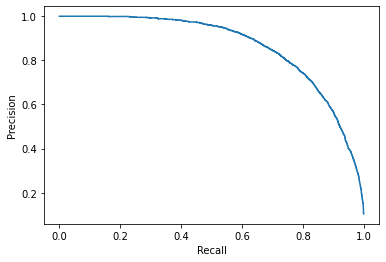

In [46]:
precision, recall, thresholds = precision_recall_curve(test_target, log_probabilities_one)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.show()

Найдём такой порог, при котором F1 максимален.

In [38]:
ind = np.where((2 * (precision * recall) / (precision + recall)) > 0.775)
ind

(array([41551, 41552, 41553, 41554, 41555, 41556, 41557, 41558, 41559,
        41560, 41561, 41562, 41563, 41564, 41565, 41566, 41567, 41568,
        41569, 41570, 41571, 41572], dtype=int64),)

In [39]:
round(thresholds[ind[0][0]], 3)

0.642

In [40]:
predictions_thr = log_balanced_model.predict_proba(test_features)[:,1] > thresholds[ind[0][0]]
round(f1_score(test_target, predictions_thr), 3)

0.775

## Вывод

Перед нами стояла задача построения модели классификации англоязычных комментариев пользователей интернет-магазина на токсичные и нетоксичные. В рамках проекта обучены и протестированы следующие модели:
- логистическая регрессия
- случайный лес
- стохастический градиентный бустинг с применением библиотек LightGBM и CatBoost

Выбранные модели показали хороший результат на обучающей выборке, однако сильно переобучились (вероятно, из-за проведённого апсемплинга). На тестовой выборке заданному критерию F1 (не менее 0,75) удовлетворяет только **модель логит-регрессии**. Её и рекомендуется использовать магазину для классификации комментариев пользователей. **Чтобы улучшить качество предсказания с точки зрения метрики F1, порог принятия решения об отнесении комментария к токсичному рекомендуется установить на уровне около 0,68**. 